In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cvxopt as opt
from cvxopt import blas, solvers
import plotly
import chart_studio
import chart_studio.plotly as py
import plotly.tools as tls
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff
import datetime
import cufflinks
import pandas as pd
from pandas import RangeIndex
import yfinance as yf
import pandas_datareader.data as web
import numpy as np
from numpy import arange
import scipy as sp
from scipy.optimize import minimize


In [3]:
# Create a random vector of multiple assets within x amount of portfolios
portfolios = 1000
assets = 6
returned_vector = np.random.randn(assets,portfolios)


In [4]:
# Before we actually analyze real stocks we need to set the stage for the portfolio optimization
# create random stock weights for analysis, the weights of the assets MUST sum to 1

assets = 6
mean_variance = []

def random_weights(assets):
    k = np.random.rand(assets)
    return k/sum(k)

random_weights(assets)

array([0.25954861, 0.17668269, 0.26620204, 0.07697328, 0.05595202,
       0.16464135])

In [5]:
# We are going to randomize returns
def random_portfolio(returns):

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(random_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This code below is necessary to get rid of outliers
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

In [6]:
# Generate a vast number of random portfolios for simulation
means, stds = np.column_stack([
    random_portfolio(returned_vector)
    for _ in RangeIndex(portfolios)
])

Text(0.5, 1.0, 'Mean and standard deviation of returns of randomly generated portfolios')

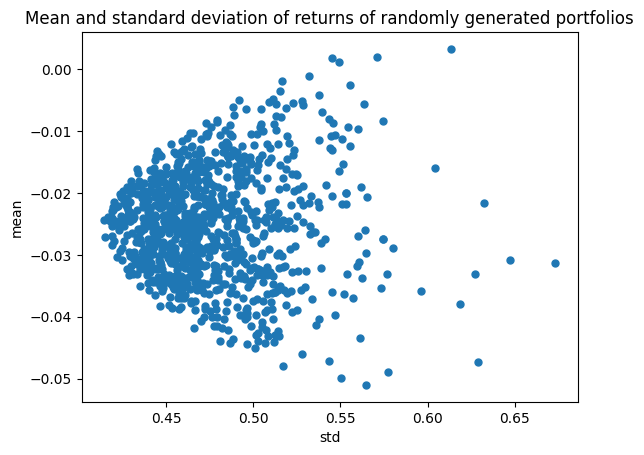

In [7]:
fig = plt.figure()
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')


     pcost       dcost       gap    pres   dres
 0:  2.7973e-02 -1.0168e+00  1e+00  1e-16  3e+00
 1:  2.6321e-02 -2.5168e-02  5e-02  2e-16  1e-01
 2:  1.0684e-02 -1.8076e-03  1e-02  1e-16  4e-17
 3:  7.1899e-03  6.1644e-03  1e-03  1e-16  4e-17
 4:  6.5629e-03  6.5303e-03  3e-05  1e-16  1e-17
 5:  6.5372e-03  6.5369e-03  3e-07  2e-16  3e-17
 6:  6.5370e-03  6.5370e-03  3e-09  1e-16  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.9116e-02 -1.0152e+00  1e+00  3e-16  3e+00
 1:  2.7510e-02 -2.3414e-02  5e-02  1e-16  1e-01
 2:  1.3264e-02  1.7137e-03  1e-02  1e-16  3e-17
 3:  1.0087e-02  9.0907e-03  1e-03  2e-16  1e-17
 4:  9.4733e-03  9.4186e-03  5e-05  2e-16  1e-17
 5:  9.4250e-03  9.4244e-03  7e-07  1e-16  1e-17
 6:  9.4244e-03  9.4244e-03  7e-09  1e-16  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.0396e-02 -1.0134e+00  1e+00  2e-16  3e+00
 1:  2.8838e-02 -2.1464e-02  5e-02  6e-17  1e-01
 2:  1.5943e-02  5.3444e

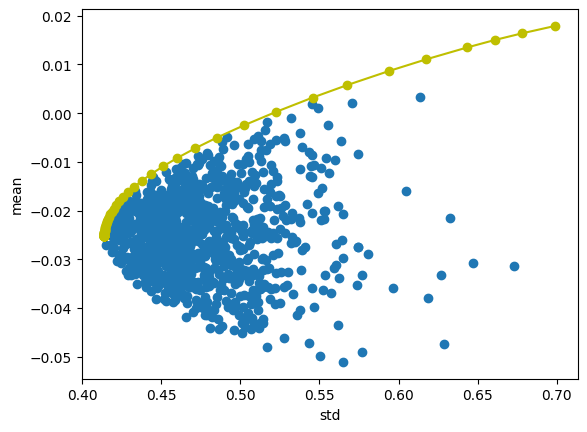

In [8]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

weights, returns, risks = optimal_portfolio(returned_vector)

fig = plt.figure()
plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')


In [9]:
# Finally print the weights we will use
print(weights)

[[1.65730803e-08]
 [7.21169884e-01]
 [2.78829779e-01]
 [6.06536531e-09]
 [9.39934372e-09]
 [3.04910790e-07]]


In [10]:
# Time to use real world data

jm = yf.download('JPM', start='2002-01-01', end='2022-12-31')
ap = yf.download('AAPL', start='2002-01-01', end='2022-12-31')
am = yf.download('AMZN', start='2002-01-01', end='2022-12-31')
wm = yf.download('WMT', start='2002-01-01', end='2022-12-31')
tg = yf.download('TGT', start='2002-01-01', end='2022-12-31')
ms = yf.download('MSFT', start='2002-01-01', end='2022-12-31')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [11]:
stocks = pd.concat([jm['Adj Close'], ap['Adj Close'], am['Adj Close'], wm['Adj Close'], tg['Adj Close'], ms['Adj Close']],axis=1)
stocks.columns = ['JP Morgan', 'Apple', 'Amazon', 'Walmart', 'Target', 'Microsoft']
stocks.to_csv('stock_data.csv')
stocks.head()

,JP Morgan,Apple,Amazon,Walmart,Target,Microsoft
Date,,,,,,
2002-01-02,19.522274,0.353637,0.5480,38.517956,26.823143,20.867460
2002-01-03,20.043226,0.357886,0.5950,38.471516,26.921272,21.549126
2002-01-04,20.945484,0.359556,0.6125,38.219376,27.438099,21.446411
2002-01-07,20.891781,0.347566,0.6170,38.080025,27.444653,21.340578
2002-01-08,20.730667,0.343164,0.5925,38.378632,27.222229,21.595816


In [12]:
# Find Returns

returns = stocks/stocks.shift(1)
returns

,JP Morgan,Apple,Amazon,Walmart,Target,Microsoft
Date,,,,,,
2002-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-03,1.026685,1.012017,1.085767,0.998794,1.003658,1.032666
2002-01-04,1.045016,1.004666,1.029412,0.993446,1.019198,0.995233
2002-01-07,0.997436,0.966653,1.007347,0.996354,1.000239,0.995065
2002-01-08,0.992288,0.987335,0.960292,1.007842,0.991896,1.011960
...,...,...,...,...,...,...
2022-12-23,1.004745,0.997202,1.017425,1.002021,1.012734,1.002267
2022-12-27,1.003504,0.986122,0.974076,1.000278,1.016766,0.992586
2022-12-28,1.005465,0.969315,0.985308,0.982477,1.001717,0.989745


In [13]:
# Fine the mean of the returns

returns.mean()

JP Morgan    1.000642
Apple        1.001354
Amazon       1.001288
Walmart      1.000333
Target       1.000514
Microsoft    1.000618
dtype: float64

In [14]:
# Need to take the logarithm of the mean for future risk analysis

log_returns = np.log(returns) 
log_returns.to_csv('stock_data.csv', index=True)
log_returns

,JP Morgan,Apple,Amazon,Walmart,Target,Microsoft
Date,,,,,,
2002-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-03,0.026335,0.011946,0.082286,-0.001206,0.003652,0.032144
2002-01-04,0.044032,0.004655,0.028988,-0.006576,0.019016,-0.004778
2002-01-07,-0.002567,-0.033916,0.007320,-0.003653,0.000239,-0.004947
2002-01-08,-0.007742,-0.012745,-0.040518,0.007811,-0.008137,0.011889
...,...,...,...,...,...,...
2022-12-23,0.004734,-0.002802,0.017274,0.002019,0.012654,0.002265
2022-12-27,0.003498,-0.013976,-0.026266,0.000278,0.016627,-0.007442
2022-12-28,0.005450,-0.031166,-0.014801,-0.017679,0.001716,-0.010308


In [15]:
# Find the expected return of the portfolio and the deviation in the portfolio returns
expected_return = log_returns.mean() * 252
deviation_return = log_returns.cov() * 252
expected_return

JP Morgan    0.091144
Apple        0.281442
Amazon       0.239905
Walmart      0.061753
Target       0.081137
Microsoft    0.116180
dtype: float64

In [16]:
# Declare a minimum return % you want on your investment
minimum_return = 0.02
number_of_assets = 6
# Create a function to set up the risk return
def risk_analysis(w):
    return np.dot(w.T,np.dot(deviation_return,w))

# Set random weight of stocks for evaluation
w0 = [0.166, 0.166, 0.166, 0.166, 0.166, 0.167]
bounds = ((0,1), (0,1), (0,1), (0,1), (0,1), (0,1))

# Creating minimum return function
def min_retrn(w):
    RHS = minimum_return - np.sum(expected_return * w)
    return RHS

def verify_min_return(w):
    return np.sum(w) - 1 

constraints = ({'type': 'eq', 'fun': min_retrn},{'type': 'eq', 'fun': verify_min_return})
optimal_weights = minimize(risk_analysis, w0, method='SLSQP', bounds=bounds, constraints=constraints)

In [17]:
optimal_weights

     fun: 0.04415857293902082
     jac: array([0.05535567, 0.04620455, 0.04926535, 0.08840575, 0.07074163,
       0.04848122])
 message: 'Positive directional derivative for linesearch'
    nfev: 163
     nit: 15
    njev: 11
  status: 8
 success: False
       x: array([1.29284725e-14, 1.75608484e-18, 2.43943305e-13, 9.98997774e-01,
       2.89722675e-18, 1.89354067e-13])

In [18]:
# use scipy for optimal weight vector

weight = optimal_weights.x
weight

array([1.29284725e-14, 1.75608484e-18, 2.43943305e-13, 9.98997774e-01,
       2.89722675e-18, 1.89354067e-13])

In [19]:
# Find weighted risk

weighted_risk = risk_analysis(weight)
weighted_risk

0.04415857293902082

In [20]:
# Take the sum of the expected return times weighted risk
np.sum(expected_return*weighted_risk)

0.03848688367173376

In [21]:
# Time for Markowitz
def markowitz(minimum_return,deviation_return,expected_return):
    N = len(deviation_return)
    o = np.ones(N)
    dev_sigma = np.linalg.inv(deviation_return)
    a = np.dot(expected_return.T, np.dot(dev_sigma,expected_return))
    b = np.dot(expected_return.T,np.dot(dev_sigma,o))
    c = np.dot(o.T,np.dot(dev_sigma,o))
    return (1/(a*c - b**2)) * np.dot(dev_sigma,((c*minimum_return - b)*expected_return + (a-b*minimum_return)*o))

In [22]:
# Now time to see the optimial risk for maximum returns with stock weights

final_analysis = markowitz(minimum_return,deviation_return,expected_return) *100
final_analysis

array([  8.66612617, -20.55068956,  -9.07525642,  85.07410329,
         7.18031467,  28.70540184])

#### The Markowitz Analysis is telling us to find better stocks than Apple and Amazon as the risk is not worth the return.

### Now let's move to see the portfolio shocked to better see what is going on. 


In [23]:
daily_returns = pd.read_csv('stock_data.csv', index_col=0)
daily_returns.head()

,JP Morgan,Apple,Amazon,Walmart,Target,Microsoft
Date,,,,,,
2002-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-03,0.026335,0.011946,0.082286,-0.001206,0.003652,0.032144
2002-01-04,0.044032,0.004655,0.028988,-0.006576,0.019016,-0.004778
2002-01-07,-0.002567,-0.033916,0.007320,-0.003653,0.000239,-0.004947
2002-01-08,-0.007742,-0.012745,-0.040518,0.007811,-0.008137,0.011889


In [24]:
# We need annualized mean returns
mus = (1+daily_returns.mean())**252 - 1

# We need the covariances of the stocks; mulitply covariance of stocks by trading days in a year, roughly 252 (this will give us)
# annualizing covariance is the square root time for volatility but no square root for variance
# a good resource for equations used --> https://quant.stackexchange.com/questions/43442/portfolio-variance-explanation-for-equation-investments-by-zvi-bodie

# a good resrouce of what annualized covariance means --> https://quant.stackexchange.com/questions/4753/annualized-covariance
cov = daily_returns.cov() * 252

In [25]:
# Indicate how many assests to include in each portfolio
number_assets = 6
# Indicate how many portfolios to generate
number_portfolios = 1000

# storing the variance pairs
mean_variance_pairs = []

np.random.seed(75)

for i in range(number_portfolios):
    
    # It is best to choose assets randomly without replacement
    assets = np.random.choice(list(daily_returns.columns), number_assets, replace=False)
    
    # It is best to choose weights randomly
    weights = np.random.rand(number_assets)
    
    # Must ensure weights sum to 1
    
    weights = weights/sum(weights)

    # Loop over asset pairs and compute portfolio return and variance
       
    portfolio_expected_variance = 0
    portfolio_expected_return = 0
    
    for i in range(len(assets)):
        portfolio_expected_return += weights[i] * mus.loc[assets[i]]
        for j in range(len(assets)):
            
            
            portfolio_expected_variance += weights[i] * weights[j] * cov.loc[assets[i], assets[j]]
            
    # Add the mean/variance pairs to a list for plotting
    mean_variance_pairs.append([portfolio_expected_return, portfolio_expected_variance])

In [26]:
#-- Plot the risk vs. return of randomly generated portfolios
#-- Convert the list from before into an array for easy plotting
mean_variance_pairs = np.array(mean_variance_pairs)

risk_free_rate=0 #-- Include risk free rate here

fig = go.Figure()
fig.add_trace(go.Scatter(x=mean_variance_pairs[:,1]**0.5, y=mean_variance_pairs[:,0], 
                      marker=dict(color=(mean_variance_pairs[:,0]-risk_free_rate)/(mean_variance_pairs[:,1]**0.5), 
                                  showscale=True, 
                                  size=7,
                                  line=dict(width=1),
                                  colorscale="RdBu",
                                  colorbar=dict(title="Sharpe<br>Ratio")
                                 ), 
                      mode='markers'))
fig.update_layout(template='plotly_white',
                  xaxis=dict(title='Annualized Risk (Volatility)'),
                  yaxis=dict(title='Annualized Return'),
                  title='Sample of Random Portfolios',
                  width=850,
                  height=500)
fig.update_xaxes(range=[0.20, 0.32])
fig.update_yaxes(range=[0.05,0.28])
fig.update_layout(coloraxis_colorbar=dict(title="Sharpe Ratio"))

In [27]:
# The expected return on our optimized portfolio return is 15.7%
portfolio_expected_return

0.15668786479923397

### Returns Forcasting with LSTM